In [19]:
def bcctcoreClassifier (asyMeasDict, colScarMeasDict):
    
    feat0=asyMeasDict['pLBC']
    
    feat1=asyMeasDict['pBCE']
    
    
    try:
        feat2=colScarMeasDict['cChi2b']
    except Exception:
        print ('NO cChi2b')
        feat2=0
   
    
    features = [feat0, feat1, feat2]
    
    return scorecardPrediction(features)
    
def scorecardPrediction(features) :
    classes = ["UNKNOWN", "EXCELLENT", "GOOD", "FAIR", "POOR"]
    prediction = -1
    points = 0.0
    if (features[0]<0.0174):
        points = 0
    elif (features[0]<0.1012):
        points = 0.1538
    elif (features[0]<0.1707):
        points = 0.4379
    else:
        points = 0.5767

    if (features[1]<0.0184):
        points += 0
    elif (features[1]<0.3684):
        points += 0.0636
    elif (features[1]<0.9219):
        points += 0.1938
    else :
        points += 0.2128

    if (features[2]<0.0140):
        points += 0
    elif (features[2]<0.0267):
        points += 0.0299
    elif (features[2]<0.6881):
        points += 0.0642
    else:
        points += 0.0727

    if (points < 0.1738):
        prediction = 1
    elif (points<0.3720):
        prediction = 2
    elif (points<0.7002):
        prediction = 3
    else:
        prediction = 4
    return prediction, classes[prediction]


### use RiskSLIM on aesthetic data only with columns chosen by old scorecard

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sbc import SBC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from scorecard import Scorecard


# columns thresholds
pLBC_thresholds = [0.0174, 0.1012, 0.1707]
pBCE_thresholds = [0.0184, 0.3684, 0.9219]
cXb2_thresholds = [0.0140, 0.0267, 0.6881]
thresholds = {
    'pLBC Value': pLBC_thresholds,
    'pBCE Value': pBCE_thresholds,
    'cX2b Value': cXb2_thresholds,
    'sbcol1': [0.5],
    'sbcol2': [0.5]
}

# prediction thresholds
prediction_thresholds = [0.1738, 0.3720, 0.7002]

# load data
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data.drop(columns='Subjective Evaluation')
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']
mapping = {4: 'Poor', 3: 'Fair', 2: 'Good', 1: 'Excellent'}
K = 4

# get train and test sets
train_X, test_X, train_y, test_y = train_test_split(aesthetic_evaluation_X, aesthetic_evaluation_y, test_size=0.25, random_state=42)

# do SBC
sbc = SBC()
sbc_train_X, sbc_train_y = sbc.reduction(train_X, train_y, K, mapping)
sbc_test_X, sbc_test_y = sbc.reduction(test_X, test_y, K, mapping)


# get encoded version of the data with differential coding
def disc_diff_coding(X, thresholds, categorical=[]):
    encoded_X = []
    for col in X.columns:
        if col not in thresholds.keys():
            continue  # skip columns not in thresholds
        if col in categorical:
            bin = pd.Categorical(X[col], categories=thresholds[col]).codes
            num_bins = len(thresholds[col])
        else:
            X_col_float = X[col].astype(float)
            bin = np.digitize(X_col_float, thresholds[col]) # gets bin number of each row
            num_bins = len(thresholds[col]) + 1
        
        bin_df = pd.DataFrame(0, index=X.index, columns=[f'feat{col}-bin{i}' for i in range(1, num_bins)])
        for i in range(1, num_bins):
            bin_df[f'feat{col}-bin{i}'] = (bin >= i).astype(int)
        
        encoded_X.append(bin_df)

    # concatenate all encoded columns
    encoded_X = pd.concat(encoded_X, axis=1)

    return encoded_X



# encode the data
encoded_train_X = disc_diff_coding(sbc_train_X, thresholds)
encoded_test_X = disc_diff_coding(sbc_test_X, thresholds)

# add the target variable as the first column, and substitute 0 by -1
encoded_train_X.insert(0, 'target', sbc_train_y.replace({0: -1}))

# to csv
encoded_train_X.to_csv('datasets/riskslim/aesthetic_old_scorecard.csv', index=False)

In [21]:
''' 
+---------------------------------------------+-------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(0 + score))   |                   |           |
| =========================================== | ================= | ========= |
| featpLBC Value-bin1                         |         -1 points |   + ..... |
| featpLBC Value-bin2                         |          1 points |   + ..... |
| featpLBC Value-bin3                         |          3 points |   + ..... |
| featpBCE Value-bin1                         |          0 points |   + ..... |
| featpBCE Value-bin2                         |          0 points |   + ..... |
| featpBCE Value-bin3                         |          0 points |   + ..... |
| featcX2b Value-bin1                         |          0 points |   + ..... |
| featcX2b Value-bin2                         |          0 points |   + ..... |
| featcX2b Value-bin3                         |          0 points |   + ..... |
| featsbcol1-bin1                             |         -2 points |   + ..... |
| featsbcol2-bin1                             |         -1 points |   + ..... |
| =========================================== | ================= | ========= |
| ADD POINTS FROM ROWS 1 to 11                |             SCORE |   = ..... |
+---------------------------------------------+-------------------+-----------+
{'L0_max': 11,
 'L0_min': 0,
 'c0_value': 1e-06,
 'callback_time': 0.002474069595336914,
 'coef_set': +---------------------+-------+------+------------+-----------+-----+
|    variable_name    | vtype | sign |     lb     |     ub    |  c0 |
+---------------------+-------+------+------------+-----------+-----+
|     (Intercept)     |   C   |  0   |   -50.0    |    50.0   | 0.0 |
| featpLBC Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpLBC Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpLBC Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpBCE Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpBCE Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpBCE Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2b Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2b Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2b Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featsbcol1-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featsbcol2-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
+---------------------+-------+------+------------+-----------+-----+,
 'data_time': 0.0002448558807373047,
 'loss_value': 0.29084659844626914,
 'nodes_processed': 0,
 'objective_value': 0.2908575984462691,
 'optimality_gap': 0.0,
 'run_time': 0.006818056106567383,
 'solution': array([ 0.03108287, -1.23667316,  1.55110331,  3.06293898, -0.13022257,
        0.10859546,  0.74391516,  0.01040377, -0.19982142, -0.98230896,
       -2.02358663, -1.93094134]),
 'solver_time': 0.004343986511230469,
 'w_pos': 1.0}
 '''

" \n+---------------------------------------------+-------------------+-----------+\n| Pr(Y = +1) = 1.0/(1.0 + exp(-(0 + score))   |                   |           |\n| =========================================== | ================= | ========= |\n| featpLBC Value-bin1                         |         -1 points |   + ..... |\n| featpLBC Value-bin2                         |          1 points |   + ..... |\n| featpLBC Value-bin3                         |          3 points |   + ..... |\n| featpBCE Value-bin1                         |          0 points |   + ..... |\n| featpBCE Value-bin2                         |          0 points |   + ..... |\n| featpBCE Value-bin3                         |          0 points |   + ..... |\n| featcX2b Value-bin1                         |          0 points |   + ..... |\n| featcX2b Value-bin2                         |          0 points |   + ..... |\n| featcX2b Value-bin3                         |          0 points |   + ..... |\n| featsbcol1-bin1       

In [22]:
solution = np.array([ 0.03108287, -1.23667316,  1.55110331,  3.06293898, 
                    -0.13022257, 0.10859546, 0.74391516, 0.01040377, 
                    -0.19982142, -0.98230896, -2.02358663, -1.93094134])

intercept = solution[0]
coefs = solution[1:]

encoded_train_X = encoded_train_X.drop(columns=['target'])

In [23]:
print(encoded_train_X.columns)
print(encoded_test_X.columns)

for col, coef in zip(encoded_train_X.columns, coefs):
    print(col, coef)
    
train_scores = intercept + np.dot(encoded_train_X, coefs)
train_probs = 1 / (1 + np.exp(-train_scores))
y_pred_train = (train_probs >= 0.5).astype(int)

test_scores = intercept + np.dot(encoded_test_X, coefs)
test_probs = 1 / (1 + np.exp(-test_scores))
y_pred_test = (test_probs >= 0.5).astype(int)

sbc_train_y_flat = sbc_train_y.values.ravel()
sbc_test_y_flat = sbc_test_y.values.ravel()
train_acc = np.mean(y_pred_train == sbc_train_y_flat)
test_acc = np.mean(y_pred_test == sbc_test_y_flat)
print("Binary Train Accuracy:", train_acc)
print("Binary Test Accuracy:", test_acc)

Index(['featpLBC Value-bin1', 'featpLBC Value-bin2', 'featpLBC Value-bin3',
       'featpBCE Value-bin1', 'featpBCE Value-bin2', 'featpBCE Value-bin3',
       'featcX2b Value-bin1', 'featcX2b Value-bin2', 'featcX2b Value-bin3',
       'featsbcol1-bin1', 'featsbcol2-bin1'],
      dtype='object')
Index(['featpLBC Value-bin1', 'featpLBC Value-bin2', 'featpLBC Value-bin3',
       'featpBCE Value-bin1', 'featpBCE Value-bin2', 'featpBCE Value-bin3',
       'featcX2b Value-bin1', 'featcX2b Value-bin2', 'featcX2b Value-bin3',
       'featsbcol1-bin1', 'featsbcol2-bin1'],
      dtype='object')
featpLBC Value-bin1 -1.23667316
featpLBC Value-bin2 1.55110331
featpLBC Value-bin3 3.06293898
featpBCE Value-bin1 -0.13022257
featpBCE Value-bin2 0.10859546
featpBCE Value-bin3 0.74391516
featcX2b Value-bin1 0.01040377
featcX2b Value-bin2 -0.19982142
featcX2b Value-bin3 -0.98230896
featsbcol1-bin1 -2.02358663
featsbcol2-bin1 -1.93094134
Binary Train Accuracy: 0.664702030124427
Binary Test Accuracy: 0.6666

In [ ]:
# compute scores for test set
scores = intercept + np.dot(encoded_test_X, coefs)

# convert score to probability
probs = 1 / (1 + np.exp(-scores))
# convert probabilities to binary predictions
y_pred = (probs >= 0.5).astype(int)

# transform predictions from binary to ordinal
sbc = SBC()
y_pred = sbc.classif(y_pred, K)
test_y = sbc.apply_mapping(test_y, mapping)

accuracy = np.mean(y_pred == test_y)
print("Test Accuracy:", accuracy)

# get train accuracy
train_scores = intercept + np.dot(encoded_train_X, coefs)
probs = 1 / (1 + np.exp(-train_scores))
y_pred_train = (probs >= 0.5).astype(int)

y_pred_train = sbc.classif(y_pred_train, K)
train_y = sbc.apply_mapping(train_y, mapping)

accuracy_train = np.mean(y_pred_train == train_y)
print("Train Accuracy:", accuracy_train)


[ 0.0258728  -1.99771383 -1.90506854 ... -0.28855735 -2.31214398
 -2.21949869]
Test Accuracy: 0.2823529411764706
Train Accuracy: 0.0


### ensemble of scorecards --> add column to aesthetic data of total number of points assigned by old scorecard and give that data to my scorecard

In [25]:
def old_scorecard_points(features) :    
    points = 0.0

    # 'pLBC Value'
    if (features[0]<0.0174):
        points = 0
    elif (features[0]<0.1012):
        points = 0.1538
    elif (features[0]<0.1707):
        points = 0.4379
    else:
        points = 0.5767

    # 'pBCE Value'
    if (features[1]<0.0184):
        points += 0
    elif (features[1]<0.3684):
        points += 0.0636
    elif (features[1]<0.9219):
        points += 0.1938
    else :
        points += 0.2128
    
    # 'cX2b Value' 
    if (features[2]<0.0140):
        points += 0
    elif (features[2]<0.0267):
        points += 0.0299
    elif (features[2]<0.6881):
        points += 0.0642
    else:
        points += 0.0727
    
    return points

Column indices for old scorecard: [0, 1, 2]


/var/folders/wk/c98ddbnx3pd7fpdy174bcjmr0000gn/T/ipykernel_24823/3943647280.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aesthetic_evaluation_X.loc[i, 'points'] = points



Objective Evaluation accuracy: 0.597

Evaluating the model on the test set...
test predictions:  [1 1 0 ... 0 0 0]
     True Value  Prediction
0             3           3
1             3           3
2             1           2
3             2           2
4             2           2
..          ...         ...
335           2           2
336           2           2
337           1           2
338           1           2
339           1           1

[340 rows x 2 columns]
accuracy:  0.5794117647058824
precision:  0.5999948485141183
recall:  0.5794117647058824
f1 score:  0.5695819696570603
balanced accuracy:  0.5283166361489335
logistic loss:  0.0572114047756279
mse:  0.5
number of far off predictions:  12
number of features:  27
number of non-zero weights:  21
model size (non-zero weights / all weights):  0.7777777777777778


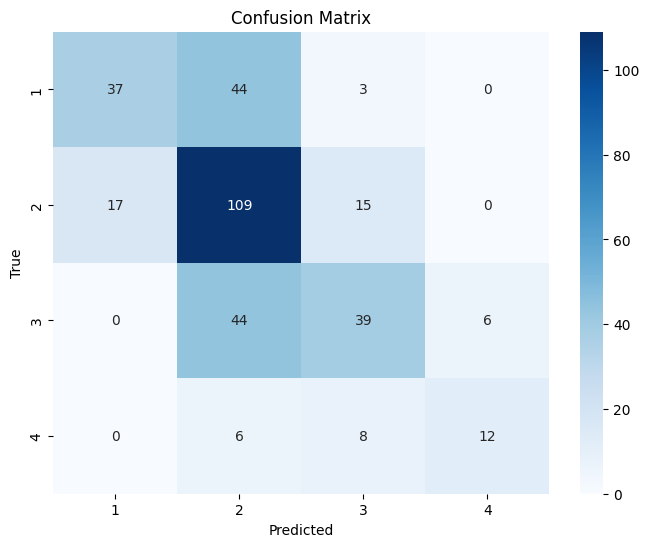

accuracy for class 1: 0.440
accuracy for class 2: 0.773
accuracy for class 3: 0.438
accuracy for class 4: 0.462

Evaluating the model on the train set...
accuracy on train set:  0.5962671905697446
precision on train set:  0.6045111919331734
recall on train set:  0.5962671905697446
f1 score on train set:  0.5820418522367582
balanced accuracy on train set:  0.5340591745809257
logistic loss on train set:  0.04434215546521338
mse on train set:  0.47544204322200395

Scorecard table:
       Feature                                        Bin    Points
0   pLBC Value   [0.0140286071627897, 0.0754687169258525[  0.630987
1   pLBC Value    [0.0754687169258525, 0.162537795701451[  1.372736
2   pLBC Value    [0.162537795701451, 0.3166823979957318[  1.401304
3   pBCE Value    [0.3034985174100497, 0.358048255463711[  0.417775
4   pBCE Value     [0.358048255463711, 0.376402851897656[  0.250183
5   pBCE Value    [0.376402851897656, 1.9451569659865504[  0.882654
6   pBCE Value                  [1.945156

In [26]:
from scorecard import Scorecard
import pandas as pd
from sklearn.metrics import accuracy_score

# load data
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_objective_evaluation = aesthetic_evaluation_data['Objective Evaluation']
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data[['pLBC Value', 'pBCE Value', 'cX2b Value', 'pUNR Value']]
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

# get indices of columns used by the old scorecard
columns = ['pLBC Value', 'pBCE Value', 'cX2b Value']
column_indices = [aesthetic_evaluation_X.columns.get_loc(col) for col in columns]
print(f'Column indices for old scorecard: {column_indices}')

# add column 'points' to X, calculated by old_scorecard_points
for i in range(aesthetic_evaluation_X.shape[0]):
    features = aesthetic_evaluation_X.iloc[i].values
    points = old_scorecard_points(features)
    aesthetic_evaluation_X.loc[i, 'points'] = points
    
scorecard = Scorecard()
model, weights = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [],
                               thresholds_method='CAIM',
                               encoding_method='DIFF_CODING',
                               model_method='ML',
                               params= {'C': 2.5, 'l1_ratio': 0.4, 'penalty': 'elasticnet', 'solver': 'saga'},
                               use_sbc=True,
                               K=4,
                               mapping = {4: 'Poor', 3: 'Fair', 2: 'Good', 1: 'Excellent'}
                               )

# see accuracy of 'Objective Evaluation' on test set
test = scorecard.test_X
test_objective = aesthetic_evaluation_objective_evaluation.loc[test.index]
objective_acc = accuracy_score(test_objective, scorecard.test_y)
print(f'\nObjective Evaluation accuracy: {objective_acc:.3f}')

scorecard.evaluate()

scorecard.show_scorecard()


Evaluating the model on the test set...
test predictions:  [1 1 1 ... 0 0 0]
     True Value  Prediction
0             3           4
1             3           2
2             1           2
3             2           2
4             2           2
..          ...         ...
335           2           2
336           2           2
337           1           2
338           1           2
339           1           1

[340 rows x 2 columns]
accuracy:  0.5088235294117647
precision:  0.5460480783126934
recall:  0.5088235294117647
f1 score:  0.4684126691497601
balanced accuracy:  0.47227461756507894
logistic loss:  0.059699685175580795
mse:  0.6647058823529411
number of far off predictions:  16
number of features:  4106
number of non-zero weights:  4100
model size (non-zero weights / all weights):  0.9985387238188017


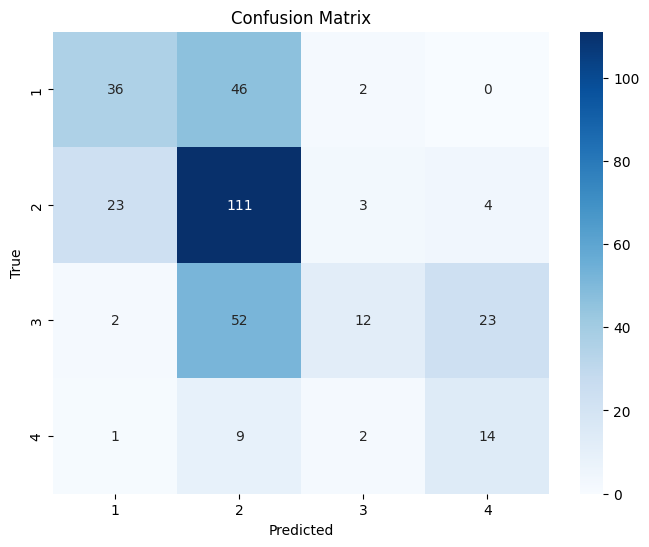

accuracy for class 1: 0.429
accuracy for class 2: 0.787
accuracy for class 3: 0.135
accuracy for class 4: 0.538

Evaluating the model on the train set...
accuracy on train set:  0.6473477406679764
precision on train set:  0.7017323704455335
recall on train set:  0.6473477406679764
f1 score on train set:  0.6057784598603058
balanced accuracy on train set:  0.6324199001207464
logistic loss on train set:  0.04800383486851113
mse on train set:  0.38212180746561886

Scorecard table:
         Feature                                             Bin    Points
0     pLBC Value  [3.2239679535846356e-05, 7.14503313927462e-05[  0.015625
1     pLBC Value  [7.14503313927462e-05, 0.00011612788529674999[ -0.009267
2     pLBC Value   [0.00011612788529674999, 0.00019454810607185[ -0.024892
3     pLBC Value        [0.00019454810607185, 0.000259873127544[ -0.032438
4     pLBC Value     [0.000259873127544, 0.00027741600466875003[ -0.016813
...          ...                                             ...   

In [27]:
scorecard = Scorecard()
model, weights = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [],
                                thresholds_method='INF_BINS',
                                encoding_method='DIFF_CODING',
                                model_method='MM',
                                params={'C': 0.015625},
                                use_sbc=True,
                                K=4,
                                mapping = {4: 'Poor', 3: 'Fair', 2: 'Good', 1: 'Excellent'}
                               )

scorecard.evaluate()

scorecard.show_scorecard()